# Credit Card Fraud Detection Project

## Introduction

This notebook explores credit card transaction data to detect fraudulent activities using machine learning models. Due to the significant class imbalance (fraud cases are much rarer than legitimate transactions), specialized resampling techniques and model evaluation metrics are required.

## Step 1: Importing Libraries & Data

In [228]:
!pip install xgboost

In [229]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import (
    make_scorer,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    auc,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    f1_score,
    accuracy_score,
)

from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

In [230]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [231]:
df.shape

(284807, 31)

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [233]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [234]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [235]:
print((df.groupby('Class')['Class'].count()/df['Class'].count())*100)

Class
0    99.827251
1     0.172749
Name: Class, dtype: float64


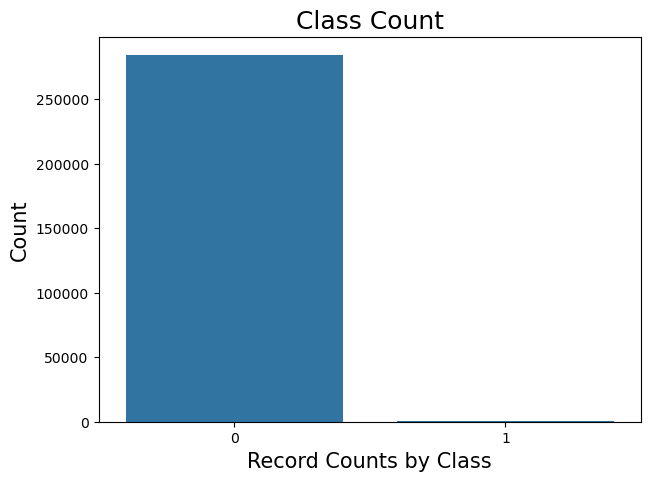

In [236]:
plt.figure(figsize=(7,5))
sns.countplot(x='Class',data= df)
plt.title("Class Count",fontsize=18)
plt.xlabel("Record Counts by Class",fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

The dataset consists of 284,807 transactions, where only 0.172% of them are fraudulent. This confirms the severe class imbalance in the dataset.

## Step 2: Exploratory Data Analysis (EDA)

- Fraud vs. Non-Fraud Distribution:

  - The dataset contains 99.83% legitimate transactions and 0.17% fraudulent transactions.


- Feature distributions are analyzed to identify significant differences between fraud and non-fraud cases.

- Correlation heatmaps and feature importance are examined to detect relationships.

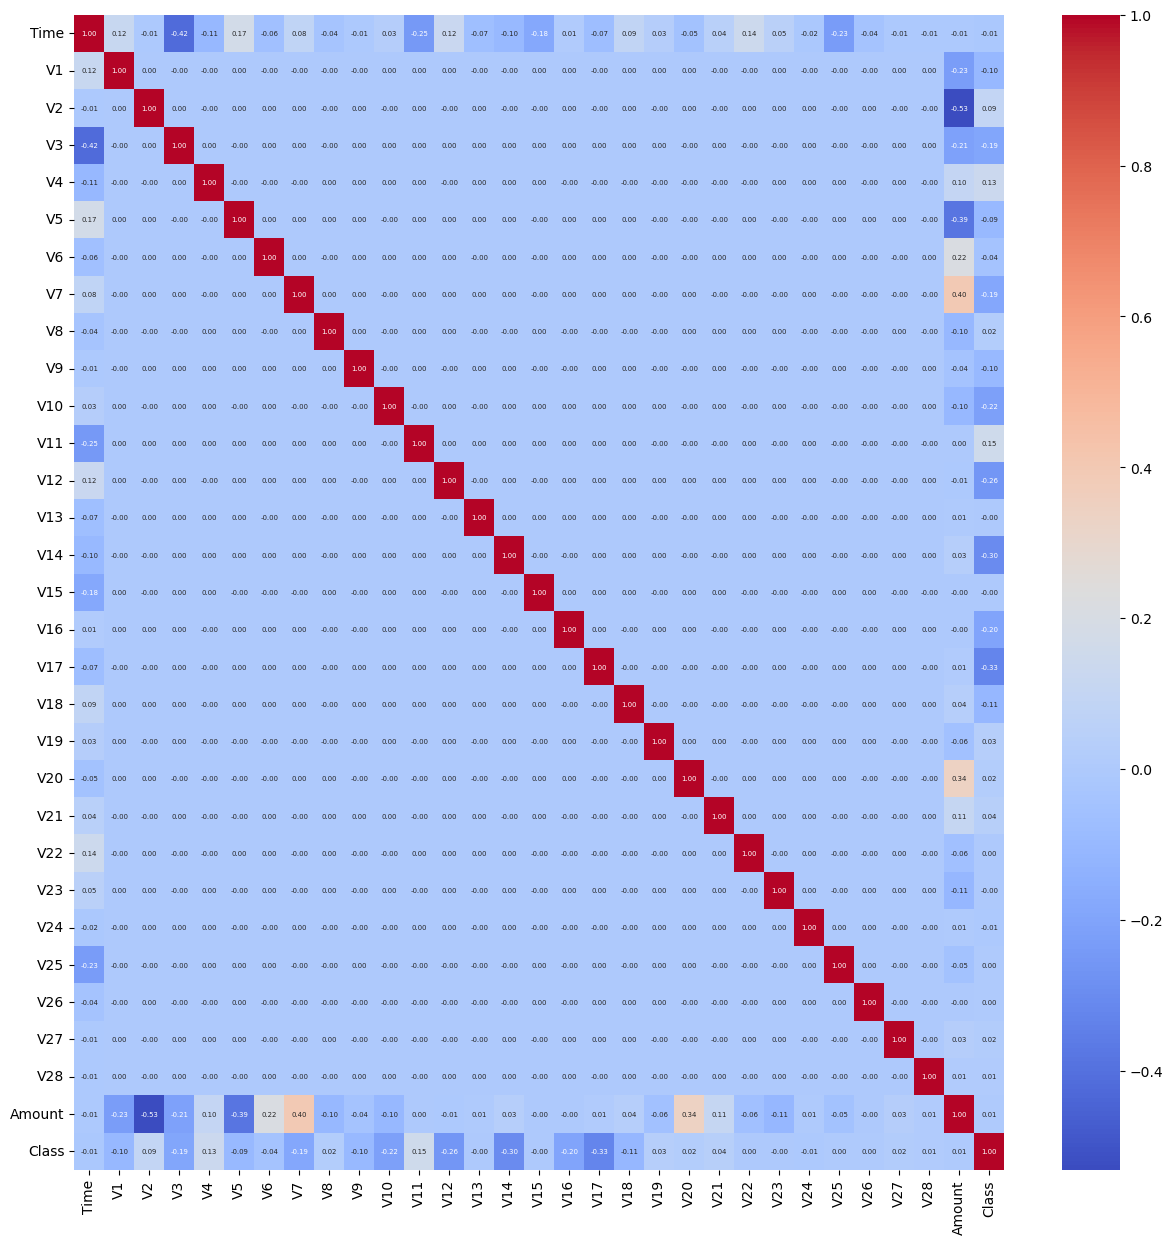

In [239]:
corr = df[df.select_dtypes(include=[np.int64,np.float64]).columns].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap = 'coolwarm', annot= True,annot_kws={"size":5},fmt='.2f');
plt.show()

In [240]:
X = df.drop('Class',axis=1)
y = df['Class']

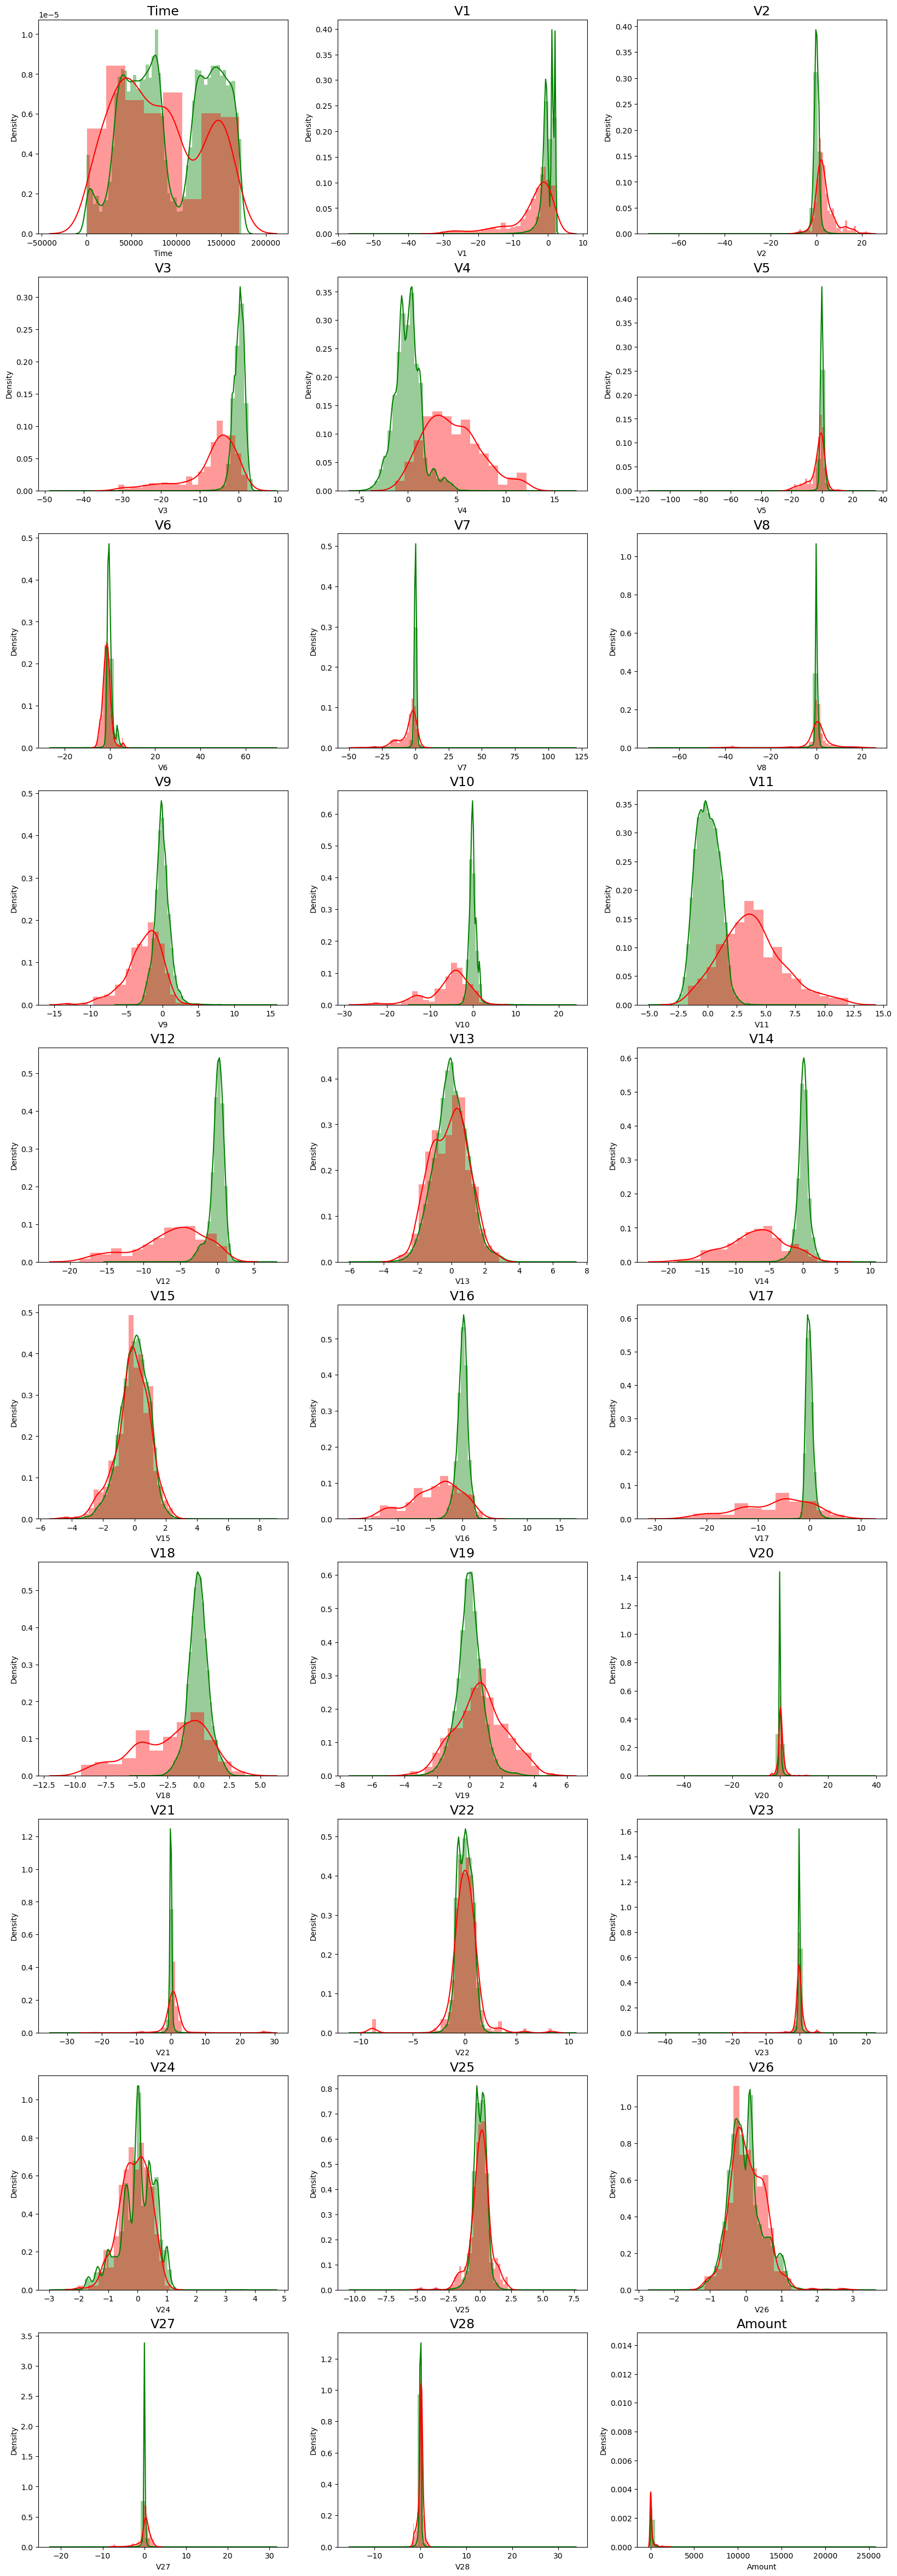

In [241]:
cols = list(X.columns.values)
normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20,60))
for n,col in enumerate(cols):
    plt.subplot(10,3,n+1)
    sns.distplot(X[col][normal_records],color='green')
    sns.distplot(X[col][fraud_records],color='red')
    plt.title(col,fontsize=17)
plt.show()

## Step 3: Data Preprocessing & Splitting

- Features are standardized using StandardScaler to normalize distributions.

- The dataset is split into training and testing sets using train_test_split.

- Handling of missing values and outliers is performed if necessary.

In [243]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()

df['Amount'] = robust.fit_transform(df[['Amount']])
df['Time'] = robust.fit_transform(df[['Time']])

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=100, test_size=0.2)

## Step 4: Model Building

In [246]:
#Create a dataframe to store results from various models for comparison later on
results = pd.DataFrame(columns=['Methodology', 'Model', 'Mean CV Accuracy', 'Mean CV PR AUC', 'Mean Threshold','Test PR AUC', 'Test Threshold'])

In [247]:
#Create function for confusion matrix to save space
def plot_cm(y_test,y_pred):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [248]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import average_precision_score, precision_recall_curve, make_scorer
def LogModelsCV(results, Methodology, X_train, y_train, n_splits=5, sampling_method=None):
    """
    Perform Cross-Validation for Logistic Regression models with L1 and L2 regularization.
    """
    if sampling_method is not None:
        X_train, y_train = sampling_method.fit_resample(X_train, y_train)
    
    # StratifiedKFold setup
    skf = StratifiedKFold(n_splits=n_splits, random_state=None)
    
    # Define PR AUC scorer
    pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)
    C = list(np.power(10.0, np.arange(-10, 10)))
    
    # L1 Regularization Model
    searchCV_l1 = LogisticRegressionCV(
        Cs=C, penalty='l1', scoring=pr_auc_scorer, cv=n_splits, random_state=42, 
        max_iter=10000, fit_intercept=True, solver='liblinear', tol=1e-3
    )
    searchCV_l1.fit(X_train, y_train)
    mean_cv_pr_auc_l1 = np.mean(searchCV_l1.scores_[1])
    mean_cv_accuracy_l1 = np.mean([
        accuracy_score(y_train.iloc[split], searchCV_l1.predict(X_train.iloc[split])) 
        for split, _ in skf.split(X_train, y_train)
    ])
    y_train_probs_l1 = searchCV_l1.predict_proba(X_train)[:, 1]
    precision_l1, recall_l1, thresholds_l1 = precision_recall_curve(y_train, y_train_probs_l1)
    mean_threshold_l1 = thresholds_l1[np.argmax(precision_l1[:-1] * recall_l1[:-1])]
    
    # L2 Regularization Model
    searchCV_l2 = LogisticRegressionCV(
        Cs=C, penalty='l2', scoring=pr_auc_scorer, cv=n_splits, random_state=42, 
        max_iter=10000, fit_intercept=True, solver='newton-cg', tol=1e-3
    )
    searchCV_l2.fit(X_train, y_train)
    mean_cv_pr_auc_l2 = np.mean(searchCV_l2.scores_[1])
    mean_cv_accuracy_l2 = np.mean([
        accuracy_score(y_train.iloc[split], searchCV_l2.predict(X_train.iloc[split])) 
        for split, _ in skf.split(X_train, y_train)
    ])
    y_train_probs_l2 = searchCV_l2.predict_proba(X_train)[:, 1]
    precision_l2, recall_l2, thresholds_l2 = precision_recall_curve(y_train, y_train_probs_l2)
    mean_threshold_l2 = thresholds_l2[np.argmax(precision_l2[:-1] * recall_l2[:-1])]
    
    # Print results
    print("L1 Regularization:")
    print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy_l1}")
    print(f"Mean Cross-Validation PR AUC: {mean_cv_pr_auc_l1}")
    print(f"Mean Cross-Validation Threshold: {mean_threshold_l1}")
    print("-" * 60)
    print("L2 Regularization:")
    print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy_l2}")
    print(f"Mean Cross-Validation PR AUC: {mean_cv_pr_auc_l2}")
    print(f"Mean Cross-Validation Threshold: {mean_threshold_l2}")
    
    # Update results for L1
    new_row_l1 = pd.DataFrame({
        'Methodology': [Methodology],
        'Model': ['Logistic Regression with L1'],
        'Mean CV Accuracy': [mean_cv_accuracy_l1],
        'Mean CV PR AUC': [mean_cv_pr_auc_l1],
        'Mean Threshold': [mean_threshold_l1],
    })
    results = pd.concat([results, new_row_l1], ignore_index=True)
    
    # Update results for L2
    new_row_l2 = pd.DataFrame({
        'Methodology': [Methodology],
        'Model': ['Logistic Regression with L2'],
        'Mean CV Accuracy': [mean_cv_accuracy_l2],
        'Mean CV PR AUC': [mean_cv_pr_auc_l2],
        'Mean Threshold': [mean_threshold_l2],
    })
    results = pd.concat([results, new_row_l2], ignore_index=True)
    
    return results, searchCV_l1, searchCV_l2

def RFModelsCV(results, Methodology, X_train, y_train, n_splits=5, sampling_method=None):
    """
    Perform Cross-Validation for Random Forest model.
    """
    if sampling_method is not None:
        X_train, y_train = sampling_method.fit_resample(X_train, y_train)
    
    rf = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features='sqrt', random_state=42)
    skf = StratifiedKFold(n_splits=n_splits, random_state=None)
    fold_accuracies, fold_pr_aucs, fold_thresholds = [], [], []
    
    print("Performing Cross-Validation...")
    for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        rf.fit(X_fold_train, y_fold_train)
        y_pred_fold = rf.predict(X_fold_test)
        y_pred_probs_fold = rf.predict_proba(X_fold_test)[:, 1]
        
        accuracy = accuracy_score(y_fold_test, y_pred_fold)
        pr_auc = average_precision_score(y_fold_test, y_pred_probs_fold)
        fold_accuracies.append(accuracy)
        fold_pr_aucs.append(pr_auc)
        
        precision, recall, thresholds = precision_recall_curve(y_fold_test, y_pred_probs_fold)
        optimal_threshold = thresholds[np.argmax(precision[:-1] * recall[:-1])]
        fold_thresholds.append(optimal_threshold)
        
        print(f"Fold {fold}: Accuracy = {accuracy}, PR AUC = {pr_auc}")
        print(f"Optimal Threshold (Fold {fold}): {optimal_threshold}")
        print("Classification Report (Fold):")
        print(classification_report(y_fold_test, y_pred_fold))
        print("Confusion Matrix (Fold):")
        plot_cm(y_fold_test, y_pred_fold)
    
    mean_accuracy = np.mean(fold_accuracies)
    mean_pr_auc = np.mean(fold_pr_aucs)
    mean_threshold = np.mean(fold_thresholds)
    print(f"Mean Cross-Validation Accuracy: {mean_accuracy}")
    print(f"Mean Cross-Validation PR AUC: {mean_pr_auc}")
    print(f"Mean Cross-Validation Threshold: {mean_threshold}")
    
    new_row = pd.DataFrame({
        'Methodology': [Methodology],
        'Model': ['Random Forest'],
        'Mean CV Accuracy': [mean_accuracy],
        'Mean CV PR AUC': [mean_pr_auc],
        'Mean Threshold': [mean_threshold],
    })
    results = pd.concat([results, new_row], ignore_index=True)
    
    return results, rf

def XGBModelsCV(results, Methodology, X_train, y_train, n_splits=5, sampling_method=None):
    """
    Perform Cross-Validation for XGBoost model.
    """
    if sampling_method is not None:
        X_train, y_train = sampling_method.fit_resample(X_train, y_train)
    
    xgb = XGBClassifier(random_state=42)
    skf = StratifiedKFold(n_splits=n_splits, random_state=None)
    fold_accuracies, fold_pr_aucs, fold_thresholds = [], [], []
    
    print("Performing Cross-Validation...")
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        xgb.fit(X_fold_train, y_fold_train)
        y_pred_fold = xgb.predict(X_fold_val)
        y_pred_probs_fold = xgb.predict_proba(X_fold_val)[:, 1]
        
        accuracy = accuracy_score(y_fold_val, y_pred_fold)
        pr_auc = average_precision_score(y_fold_val, y_pred_probs_fold)
        fold_accuracies.append(accuracy)
        fold_pr_aucs.append(pr_auc)
        
        precision, recall, thresholds = precision_recall_curve(y_fold_val, y_pred_probs_fold)
        optimal_threshold = thresholds[np.argmax(precision[:-1] * recall[:-1])]
        fold_thresholds.append(optimal_threshold)
        
        print(f"Fold {fold}: Accuracy = {accuracy}, PR AUC = {pr_auc}")
        print(f"Optimal Threshold (Fold {fold}): {optimal_threshold}")
        print("Classification Report (Fold):")
        print(classification_report(y_fold_val, y_pred_fold))
        print("Confusion Matrix (Fold):")
        plot_cm(y_fold_val, y_pred_fold)
    
    mean_accuracy = np.mean(fold_accuracies)
    mean_pr_auc = np.mean(fold_pr_aucs)
    mean_threshold = np.mean(fold_thresholds)
    print(f"Mean Cross-Validation Accuracy: {mean_accuracy}")
    print(f"Mean Cross-Validation PR AUC: {mean_pr_auc}")
    print(f"Mean Cross-Validation Threshold: {mean_threshold}")
    
    new_row = pd.DataFrame({
        'Methodology': [Methodology],
        'Model': ['XGBoost'],
        'Mean CV Accuracy': [mean_accuracy],
        'Mean CV PR AUC': [mean_pr_auc],
        'Mean Threshold': [mean_threshold],
    })
    results = pd.concat([results, new_row], ignore_index=True)
    
    return results, xgb

In [249]:
def UnifiedTest(results, Methodology, X_test, y_test, model):
    """
    Evaluate any trained model on the test set.
    Parameters:
    - results: DataFrame to store results.
    - Methodology: Description of the methodology used.
    - X_test: Test features.
    - y_test: Test labels.
    - model: Trained model (LogisticRegressionCV, RandomForestClassifier, or XGBClassifier).
    Returns:
    - Updated results DataFrame.
    """
    print("Evaluating on the Test Set...")
    y_pred_test = model.predict(X_test)
    y_pred_probs_test = model.predict_proba(X_test)[:, 1]
    test_pr_auc = average_precision_score(y_test, y_pred_probs_test)
    
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_probs_test)
    test_threshold = thresholds_test[np.argmax(precision_test[:-1] * recall_test[:-1])]
    
    print(f"Test PR AUC: {test_pr_auc}")
    print(f"Optimal Test Threshold: {test_threshold}")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_pred_test))
    print("Confusion Matrix (Test):")
    plot_cm(y_test, y_pred_test)
    
    # Plot Precision-Recall curve for the test set
    plt.plot(recall_test, precision_test, label=f'Test Data, PR AUC = {test_pr_auc}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc=4)
    plt.show()
    
    # Determine the model name
    if isinstance(model, LogisticRegressionCV):
        model_name = "Logistic Regression"
    elif isinstance(model, RandomForestClassifier):
        model_name = "Random Forest"
    elif isinstance(model, XGBClassifier):
        model_name = "XGBoost"
    else:
        raise ValueError("Unsupported model type.")
    
    # Update results DataFrame
    new_row = pd.DataFrame({
        'Methodology': [Methodology],
        'Model': [model_name],
        'Test PR AUC': [test_pr_auc],
        'Test Threshold': [test_threshold],
    })
    results = pd.concat([results, new_row], ignore_index=True)
    
    return results

### Perform the Cross Validation on the Training Data

Logistic Regression with L1 and L2 Regularization
L1 Regularization:
Mean Cross-Validation Accuracy: 0.9992582676819767
Mean Cross-Validation PR AUC: 0.4713179503263694
Mean Cross-Validation Threshold: 0.11230865174907158
------------------------------------------------------------
L2 Regularization:
Mean Cross-Validation Accuracy: 0.9992056002984485
Mean Cross-Validation PR AUC: 0.5564158600014889
Mean Cross-Validation Threshold: 0.07373265859610814
Time Taken by Model: --- 119.43897104263306 seconds ---
------------------------------------------------------------
Random Forest Model
Performing Cross-Validation...
Fold 1: Accuracy = 0.9997147183392219, PR AUC = 0.9215799989710373
Optimal Threshold (Fold 1): 0.36
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45491
           1       0.99      0.85      0.91        78

    accuracy                           1.00     45569
   macro avg       0.99      

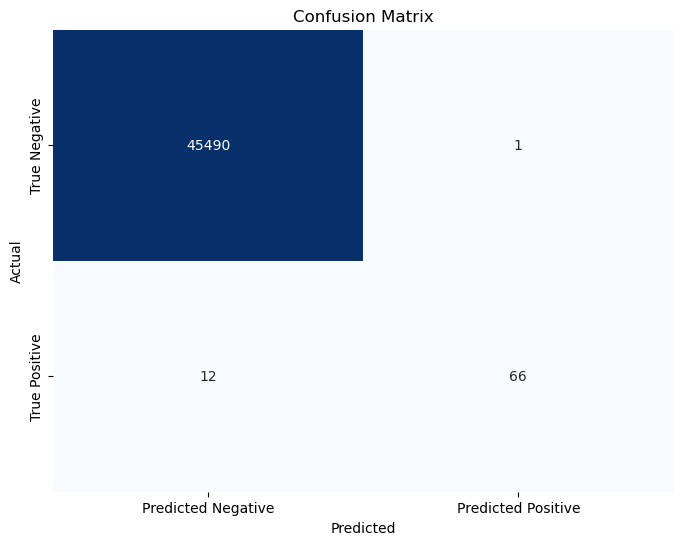

Fold 2: Accuracy = 0.9995172156509908, PR AUC = 0.8412131308062853
Optimal Threshold (Fold 2): 0.32
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.91      0.80      0.85        79

    accuracy                           1.00     45569
   macro avg       0.96      0.90      0.93     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


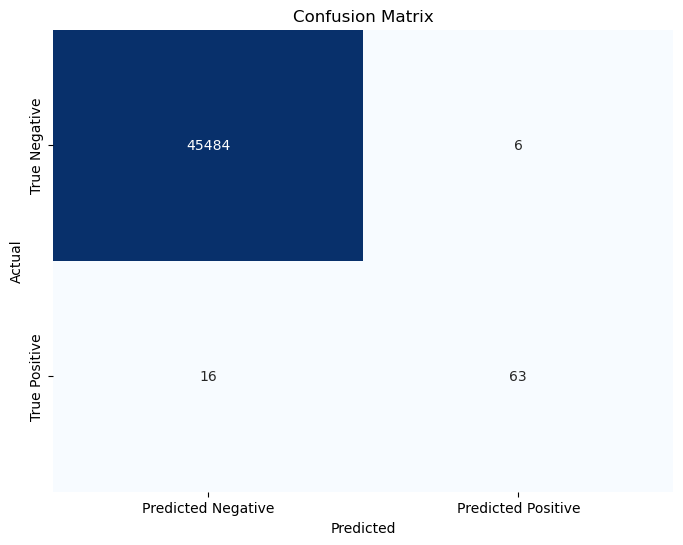

Fold 3: Accuracy = 0.9993855471921701, PR AUC = 0.7706628973791361
Optimal Threshold (Fold 3): 0.55
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.89      0.73      0.81        79

    accuracy                           1.00     45569
   macro avg       0.95      0.87      0.90     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


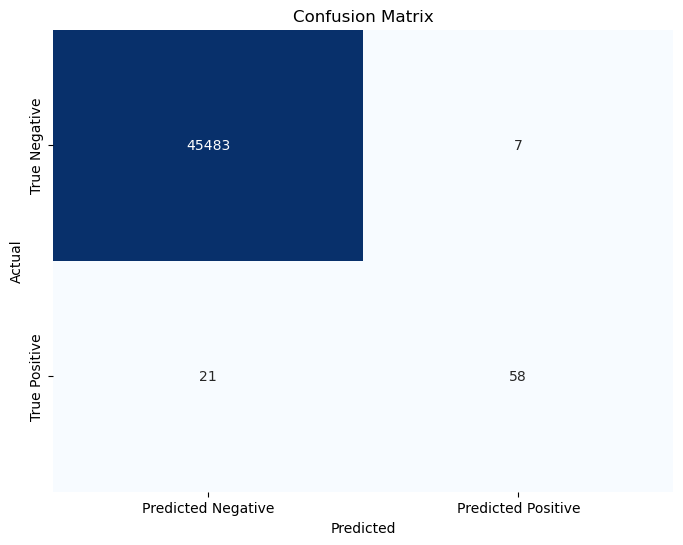

Fold 4: Accuracy = 0.9994513814215804, PR AUC = 0.808932788848917
Optimal Threshold (Fold 4): 0.43
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.94      0.73      0.82        79

    accuracy                           1.00     45569
   macro avg       0.97      0.87      0.91     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


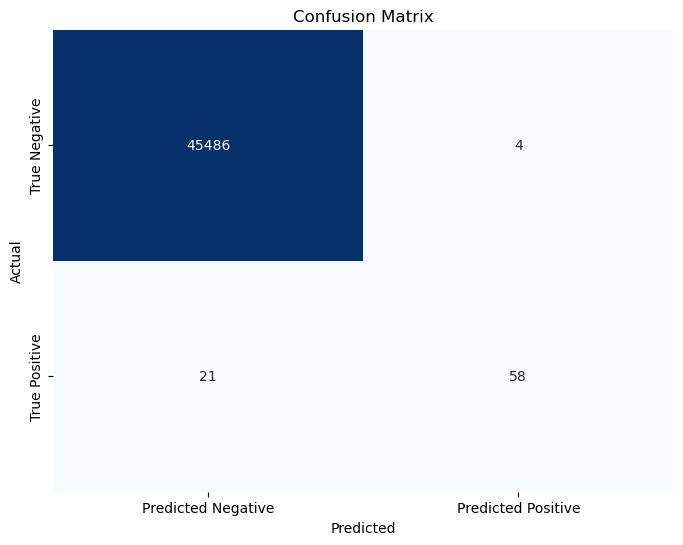

Fold 5: Accuracy = 0.9996488841098115, PR AUC = 0.8748560199626092
Optimal Threshold (Fold 5): 0.39
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.97      0.82      0.89        79

    accuracy                           1.00     45569
   macro avg       0.98      0.91      0.95     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


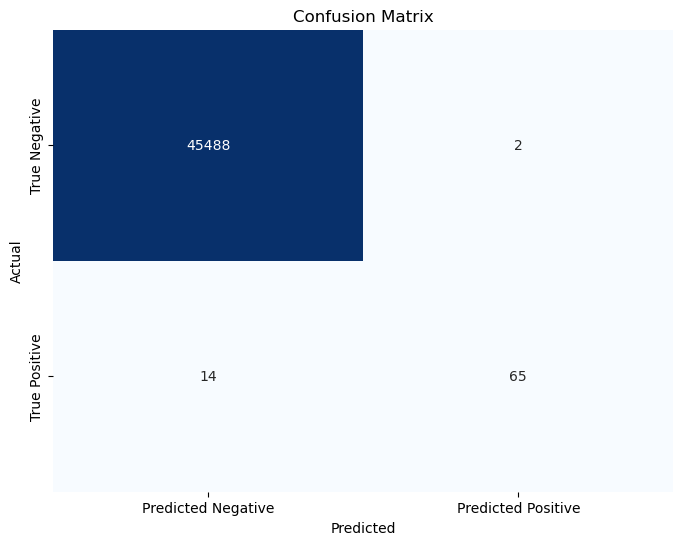

Mean Cross-Validation Accuracy: 0.999543549342755
Mean Cross-Validation PR AUC: 0.843448967193597
Mean Cross-Validation Threshold: 0.41
Time Taken by Model: --- 474.77728509902954 seconds ---
------------------------------------------------------------
XGBoost Model
Performing Cross-Validation...
Fold 1: Accuracy = 0.9997805525686322, PR AUC = 0.9266438488803355
Optimal Threshold (Fold 1): 0.6985010504722595
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45491
           1       1.00      0.87      0.93        78

    accuracy                           1.00     45569
   macro avg       1.00      0.94      0.97     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


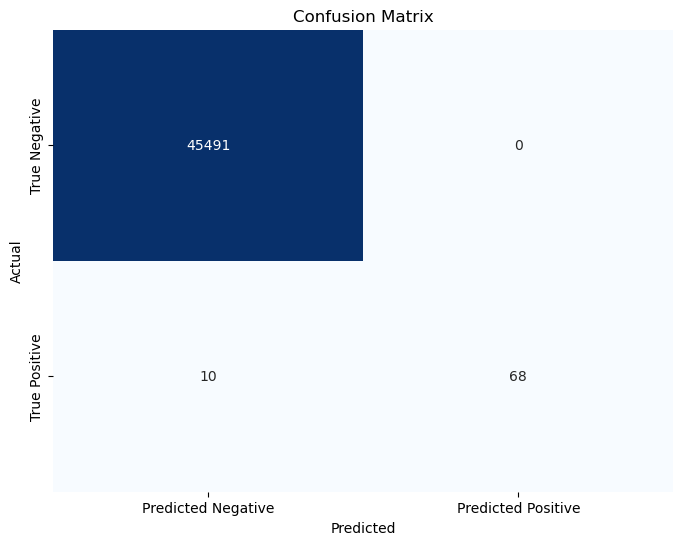

Fold 2: Accuracy = 0.9996488841098115, PR AUC = 0.8619469103950419
Optimal Threshold (Fold 2): 0.5872388482093811
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.94      0.85      0.89        79

    accuracy                           1.00     45569
   macro avg       0.97      0.92      0.95     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


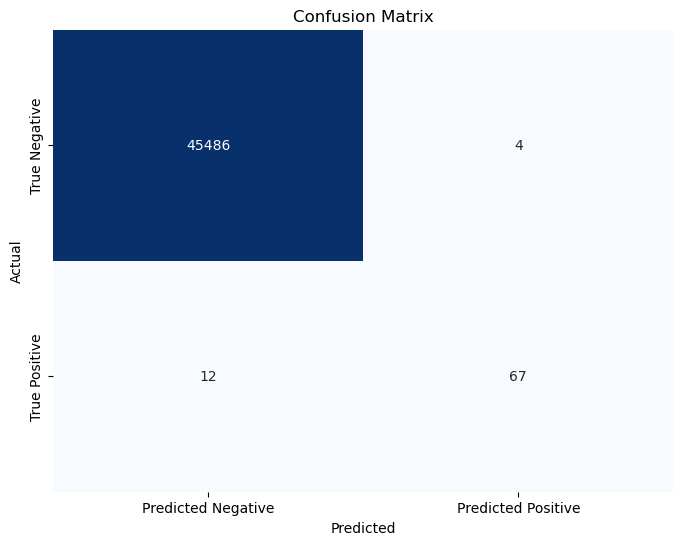

Fold 3: Accuracy = 0.9993855471921701, PR AUC = 0.7599278155739368
Optimal Threshold (Fold 3): 0.3293934762477875
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.88      0.75      0.81        79

    accuracy                           1.00     45569
   macro avg       0.94      0.87      0.90     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


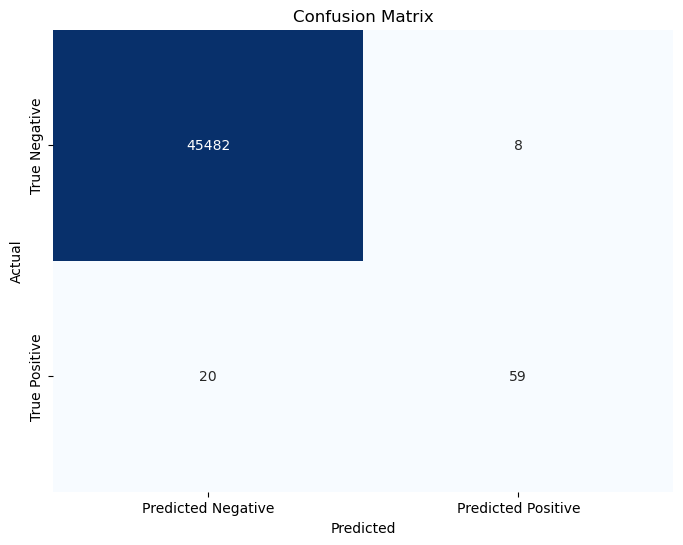

Fold 4: Accuracy = 0.9994952709078541, PR AUC = 0.8072339039928356
Optimal Threshold (Fold 4): 0.7027403116226196
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.95      0.75      0.84        79

    accuracy                           1.00     45569
   macro avg       0.98      0.87      0.92     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


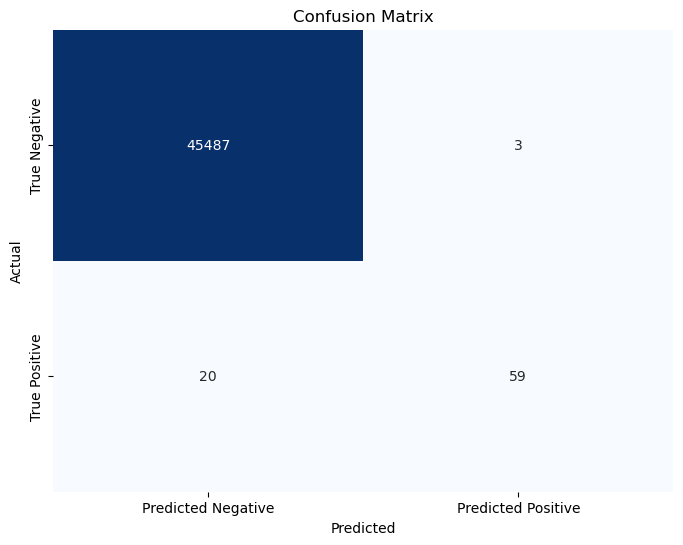

Fold 5: Accuracy = 0.9996488841098115, PR AUC = 0.8799555264535489
Optimal Threshold (Fold 5): 0.13503509759902954
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.97      0.82      0.89        79

    accuracy                           1.00     45569
   macro avg       0.98      0.91      0.95     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix (Fold):


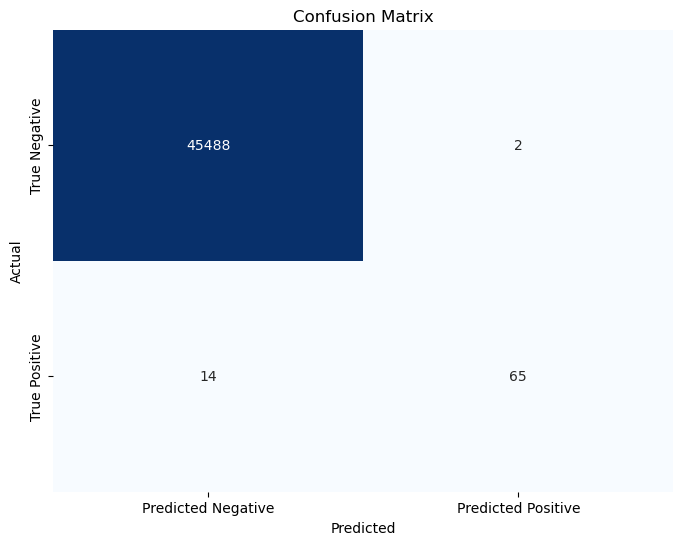

Mean Cross-Validation Accuracy: 0.9995918277776559
Mean Cross-Validation PR AUC: 0.8471416010591397
Mean Cross-Validation Threshold: 0.490581750869751
Time Taken by Model: --- 4.689090967178345 seconds ---
------------------------------------------------------------


In [251]:
# Run Logistic Regression with L1 and L2 Regularization
print("Logistic Regression with L1 and L2 Regularization")
start_time = time.time()
results, log_l1_cv, log_l2_cv = LogModelsCV(results, "StratifiedKFold Cross Validation", X_train, y_train, n_splits=5,sampling_method=None)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

# Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
results, rf_cv = RFModelsCV(results, "StratifiedKFold Cross Validation", X_train, y_train, n_splits=5,sampling_method=None)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

# Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
results, xgb_cv = XGBModelsCV(results, "StratifiedKFold Cross Validation", X_train, y_train, n_splits=5,sampling_method=None)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

### Print Results dataset

In [253]:
print(results)

                        Methodology                        Model  \
0  StratifiedKFold Cross Validation  Logistic Regression with L1   
1  StratifiedKFold Cross Validation  Logistic Regression with L2   
2  StratifiedKFold Cross Validation                Random Forest   
3  StratifiedKFold Cross Validation                      XGBoost   

   Mean CV Accuracy  Mean CV PR AUC  Mean Threshold Test PR AUC Test Threshold  
0          0.999258        0.471318        0.112309         NaN            NaN  
1          0.999206        0.556416        0.073733         NaN            NaN  
2          0.999544        0.843449        0.410000         NaN            NaN  
3          0.999592        0.847142        0.490582         NaN            NaN  


## Balancing Classes Using SMOTE and ADASYN

Random Forest Model with SMOTE
Performing Cross-Validation...
Fold 1: Accuracy = 0.9999340521647377, PR AUC = 0.9999999758359014
Optimal Threshold (Fold 1): 0.48
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45491
           1       1.00      1.00      1.00     45490

    accuracy                           1.00     90981
   macro avg       1.00      1.00      1.00     90981
weighted avg       1.00      1.00      1.00     90981

Confusion Matrix (Fold):


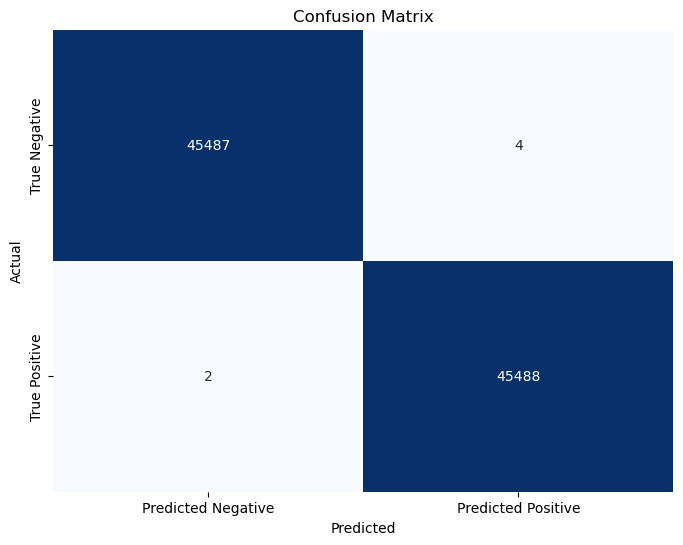

Fold 2: Accuracy = 0.9998241391059671, PR AUC = 0.9999982567773161
Optimal Threshold (Fold 2): 0.71
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45491

    accuracy                           1.00     90981
   macro avg       1.00      1.00      1.00     90981
weighted avg       1.00      1.00      1.00     90981

Confusion Matrix (Fold):


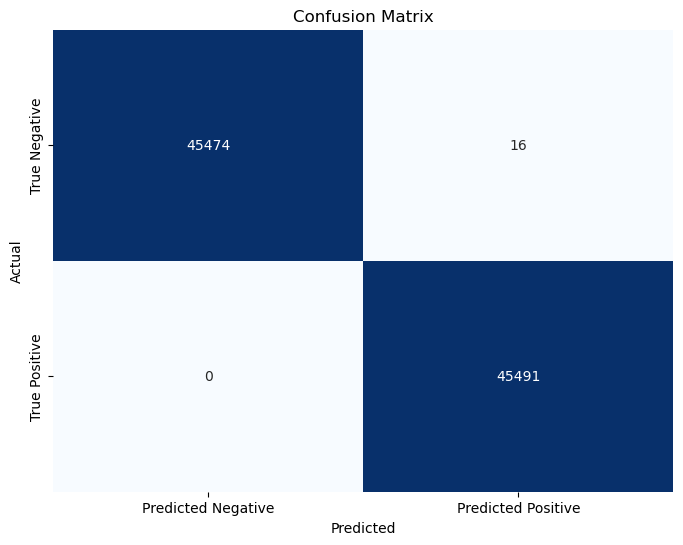

Fold 3: Accuracy = 0.9998571114530667, PR AUC = 0.9999727557006478
Optimal Threshold (Fold 3): 0.68
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45490

    accuracy                           1.00     90980
   macro avg       1.00      1.00      1.00     90980
weighted avg       1.00      1.00      1.00     90980

Confusion Matrix (Fold):


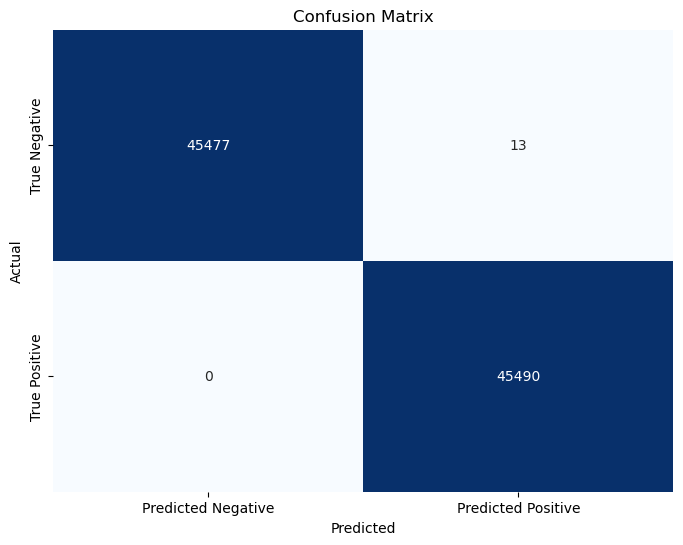

Fold 4: Accuracy = 0.9999670257199385, PR AUC = 0.9999999143720156
Optimal Threshold (Fold 4): 0.6
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45490

    accuracy                           1.00     90980
   macro avg       1.00      1.00      1.00     90980
weighted avg       1.00      1.00      1.00     90980

Confusion Matrix (Fold):


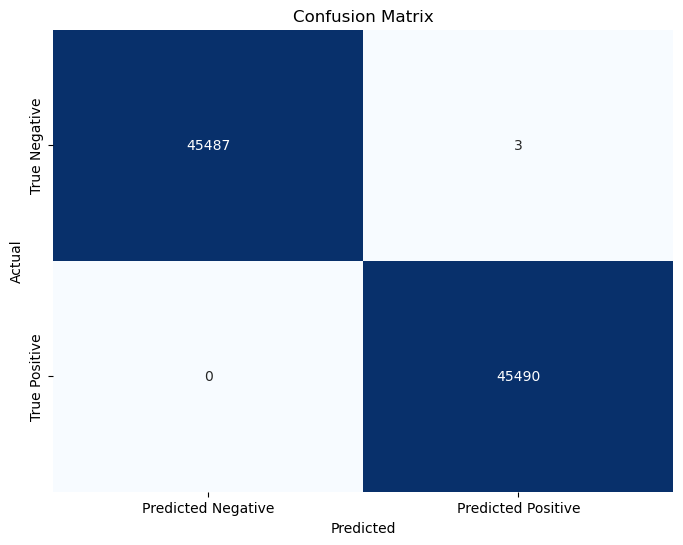

Fold 5: Accuracy = 0.9999340514398769, PR AUC = 0.9999998208104941
Optimal Threshold (Fold 5): 0.75
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45490

    accuracy                           1.00     90980
   macro avg       1.00      1.00      1.00     90980
weighted avg       1.00      1.00      1.00     90980

Confusion Matrix (Fold):


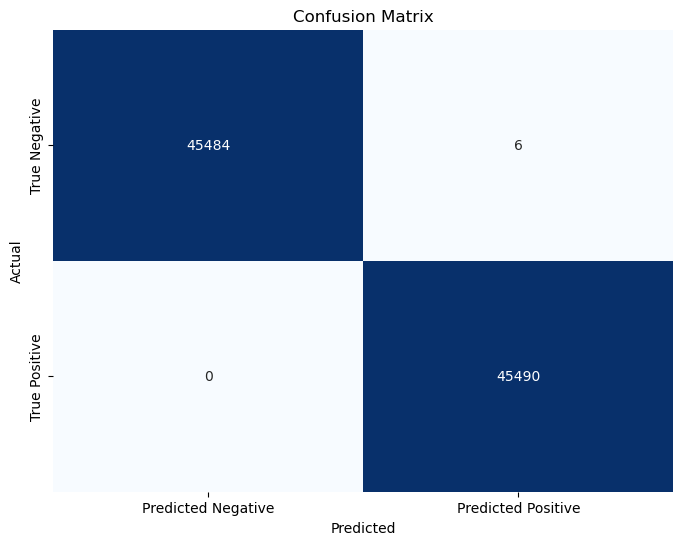

Mean Cross-Validation Accuracy: 0.9999032759767175
Mean Cross-Validation PR AUC: 0.9999941446992751
Mean Cross-Validation Threshold: 0.644
Time Taken by Model: --- 866.2015881538391 seconds ---
------------------------------------------------------------
XGBoost Model with SMOTE
Performing Cross-Validation...
Fold 1: Accuracy = 0.9998681043294754, PR AUC = 0.9999991682552356
Optimal Threshold (Fold 1): 0.6219061613082886
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45491
           1       1.00      1.00      1.00     45490

    accuracy                           1.00     90981
   macro avg       1.00      1.00      1.00     90981
weighted avg       1.00      1.00      1.00     90981

Confusion Matrix (Fold):


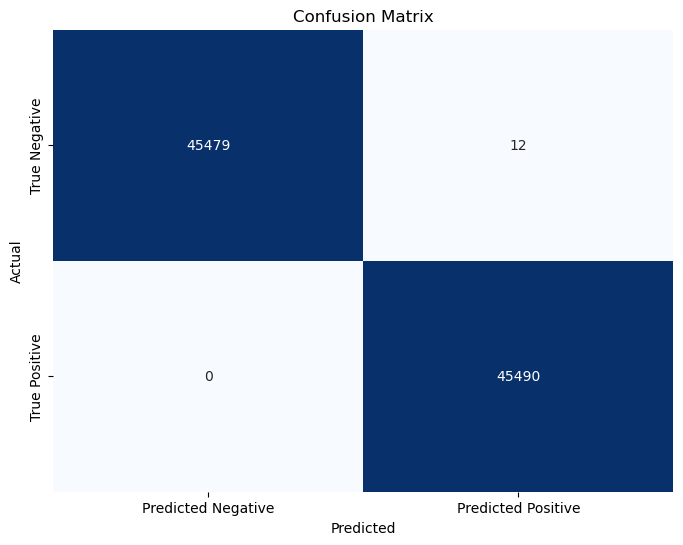

Fold 2: Accuracy = 0.9998131478000901, PR AUC = 0.9999913321487024
Optimal Threshold (Fold 2): 0.9346636533737183
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45491

    accuracy                           1.00     90981
   macro avg       1.00      1.00      1.00     90981
weighted avg       1.00      1.00      1.00     90981

Confusion Matrix (Fold):


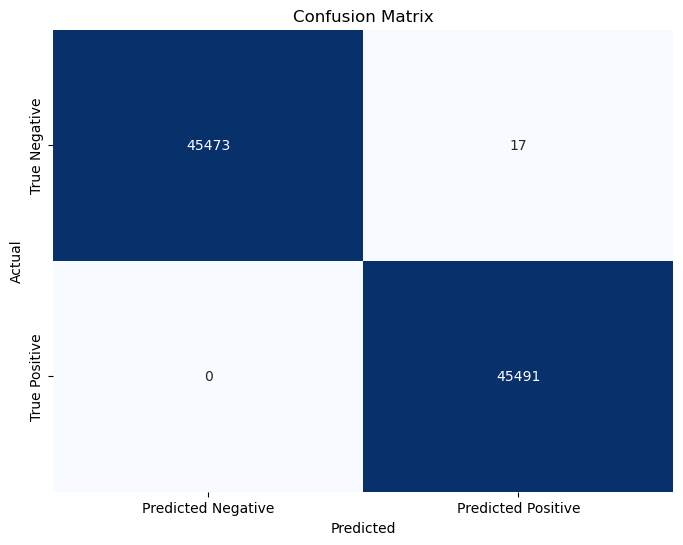

Fold 3: Accuracy = 0.9998131457463179, PR AUC = 0.9999329670625109
Optimal Threshold (Fold 3): 0.9715427160263062
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45490

    accuracy                           1.00     90980
   macro avg       1.00      1.00      1.00     90980
weighted avg       1.00      1.00      1.00     90980

Confusion Matrix (Fold):


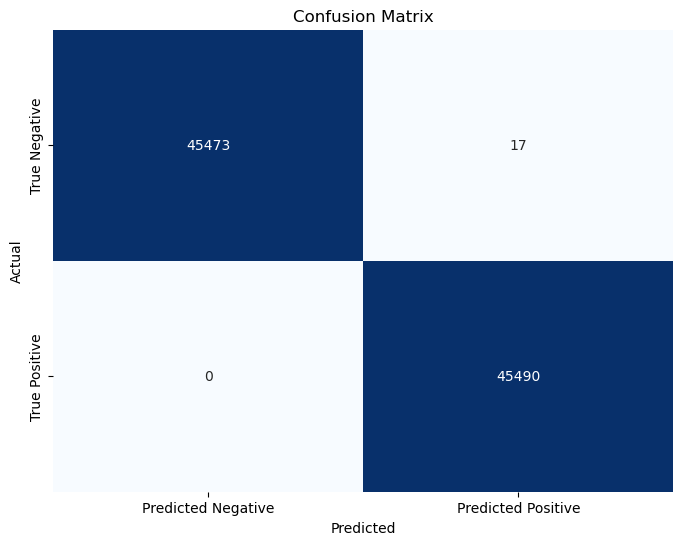

Fold 4: Accuracy = 0.9998571114530667, PR AUC = 0.9999962479751824
Optimal Threshold (Fold 4): 0.947904109954834
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45490

    accuracy                           1.00     90980
   macro avg       1.00      1.00      1.00     90980
weighted avg       1.00      1.00      1.00     90980

Confusion Matrix (Fold):


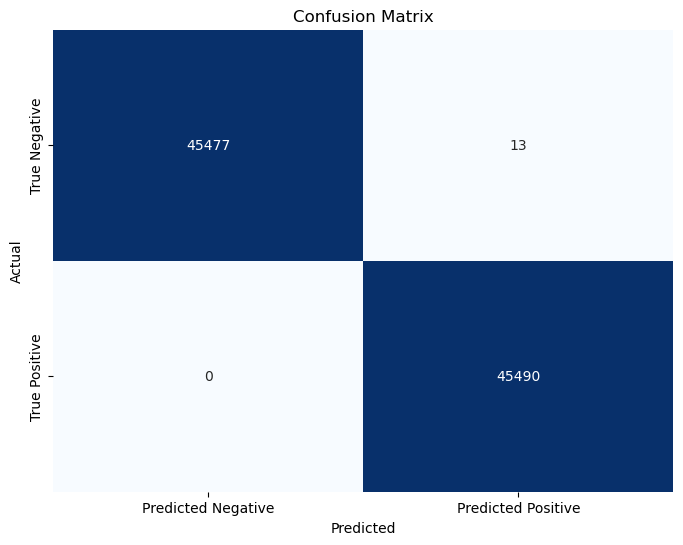

Fold 5: Accuracy = 0.9999120685865025, PR AUC = 0.9999971198213424
Optimal Threshold (Fold 5): 0.9407032132148743
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45490

    accuracy                           1.00     90980
   macro avg       1.00      1.00      1.00     90980
weighted avg       1.00      1.00      1.00     90980

Confusion Matrix (Fold):


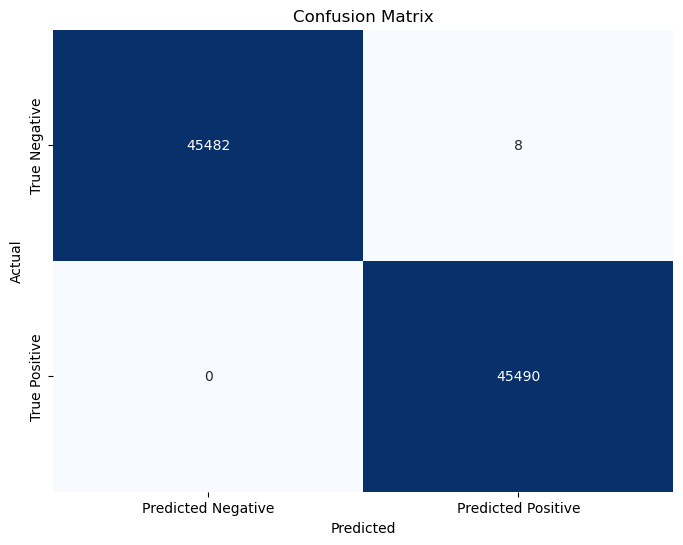

Mean Cross-Validation Accuracy: 0.9998527155830905
Mean Cross-Validation PR AUC: 0.9999833670525948
Mean Cross-Validation Threshold: 0.8833439946174622
Time Taken by Model: --- 10.085174798965454 seconds ---
------------------------------------------------------------


In [255]:
#use the above code to run it again after resampling the training data and feeding it into the 
#fucntion as x_train and y_train
from imblearn.over_sampling import SMOTE

# Initialize SMOTE for oversampling
smote = SMOTE(random_state=0)

# Run Random Forest Model with SMOTE
print("Random Forest Model with SMOTE")
start_time = time.time()
results, rf_smote = RFModelsCV(results, "SMOTE StratifiedKFold Cross Validation", X_train, y_train, n_splits=5,sampling_method=smote)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

# Run XGBoost Model with SMOTE
print("XGBoost Model with SMOTE")
start_time = time.time()
results, xgb_smote = XGBModelsCV(results, "SMOTE StratifiedKFold Cross Validation", X_train, y_train, n_splits=5,sampling_method=smote)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

Random Forest Model with ADASYN
Performing Cross-Validation...
Fold 1: Accuracy = 0.9997251388049035, PR AUC = 0.9999996208401373
Optimal Threshold (Fold 1): 0.44
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45491
           1       1.00      1.00      1.00     45464

    accuracy                           1.00     90955
   macro avg       1.00      1.00      1.00     90955
weighted avg       1.00      1.00      1.00     90955

Confusion Matrix (Fold):


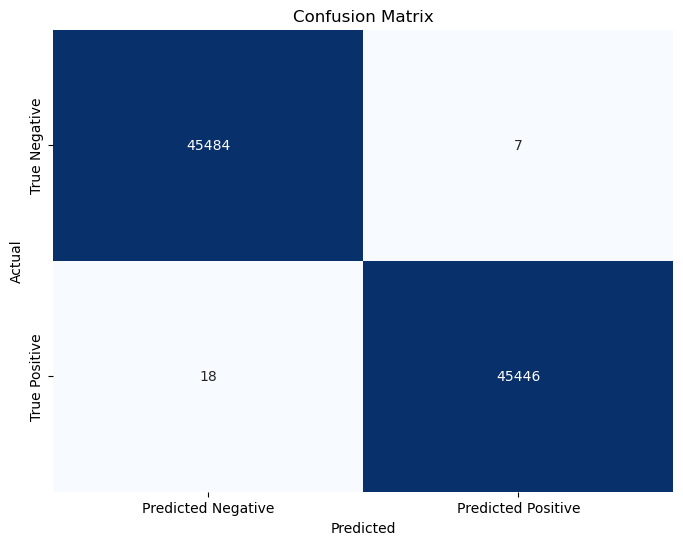

Fold 2: Accuracy = 0.99407399263372, PR AUC = 0.9992186060357513
Optimal Threshold (Fold 2): 0.22
Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45490
           1       1.00      0.99      0.99     45465

    accuracy                           0.99     90955
   macro avg       0.99      0.99      0.99     90955
weighted avg       0.99      0.99      0.99     90955

Confusion Matrix (Fold):


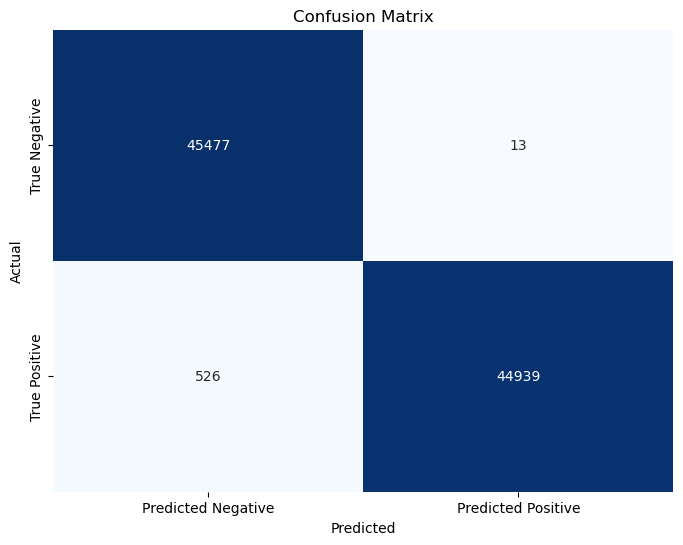

Fold 3: Accuracy = 0.9885987576273981, PR AUC = 0.9983798904105279
Optimal Threshold (Fold 3): 0.1
Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     45490
           1       1.00      0.98      0.99     45465

    accuracy                           0.99     90955
   macro avg       0.99      0.99      0.99     90955
weighted avg       0.99      0.99      0.99     90955

Confusion Matrix (Fold):


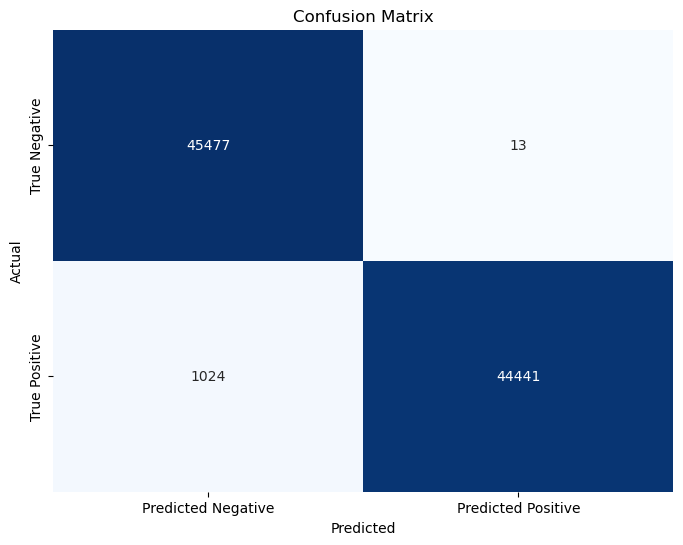

Fold 4: Accuracy = 0.9904788082018581, PR AUC = 0.9999459729210725
Optimal Threshold (Fold 4): 0.18
Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     45490
           1       1.00      0.98      0.99     45465

    accuracy                           0.99     90955
   macro avg       0.99      0.99      0.99     90955
weighted avg       0.99      0.99      0.99     90955

Confusion Matrix (Fold):


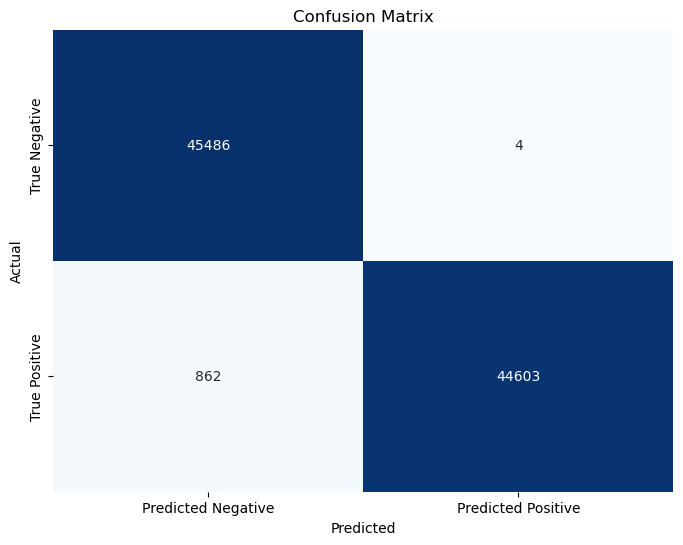

Fold 5: Accuracy = 0.9944697319524155, PR AUC = 0.999986937331631
Optimal Threshold (Fold 5): 0.15
Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45490
           1       1.00      0.99      0.99     45464

    accuracy                           0.99     90954
   macro avg       0.99      0.99      0.99     90954
weighted avg       0.99      0.99      0.99     90954

Confusion Matrix (Fold):


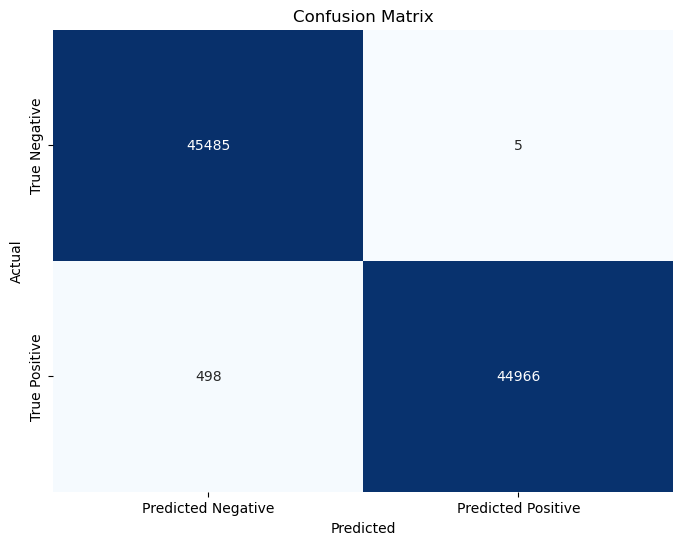

Mean Cross-Validation Accuracy: 0.9934692858440591
Mean Cross-Validation PR AUC: 0.999506205507824
Mean Cross-Validation Threshold: 0.21799999999999997
Time Taken by Model: --- 860.295735836029 seconds ---
------------------------------------------------------------
XGBoost Model with ADASYN
Performing Cross-Validation...
Fold 1: Accuracy = 0.9998570721785498, PR AUC = 0.9999988522294893
Optimal Threshold (Fold 1): 0.7145336270332336
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45491
           1       1.00      1.00      1.00     45464

    accuracy                           1.00     90955
   macro avg       1.00      1.00      1.00     90955
weighted avg       1.00      1.00      1.00     90955

Confusion Matrix (Fold):


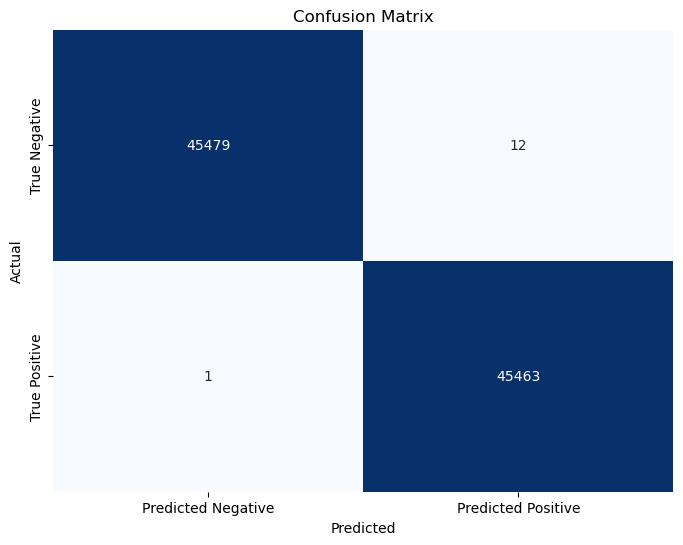

Fold 2: Accuracy = 0.9965807267329998, PR AUC = 0.9999628074562944
Optimal Threshold (Fold 2): 0.019053924828767776
Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     45490
           1       1.00      0.99      1.00     45465

    accuracy                           1.00     90955
   macro avg       1.00      1.00      1.00     90955
weighted avg       1.00      1.00      1.00     90955

Confusion Matrix (Fold):


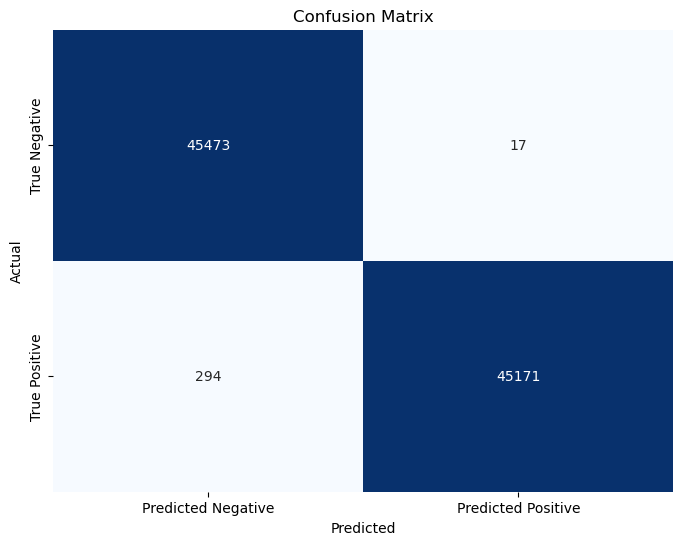

Fold 3: Accuracy = 0.9915342751910285, PR AUC = 0.9997109580087514
Optimal Threshold (Fold 3): 0.009211676195263863
Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     45490
           1       1.00      0.98      0.99     45465

    accuracy                           0.99     90955
   macro avg       0.99      0.99      0.99     90955
weighted avg       0.99      0.99      0.99     90955

Confusion Matrix (Fold):


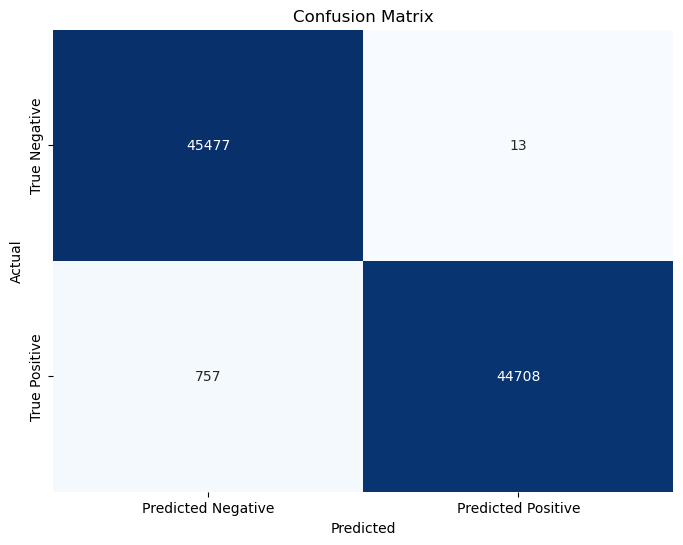

Fold 4: Accuracy = 0.9960200098950031, PR AUC = 0.9999710435018643
Optimal Threshold (Fold 4): 0.01772315427660942
Classification Report (Fold):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     45490
           1       1.00      0.99      1.00     45465

    accuracy                           1.00     90955
   macro avg       1.00      1.00      1.00     90955
weighted avg       1.00      1.00      1.00     90955

Confusion Matrix (Fold):


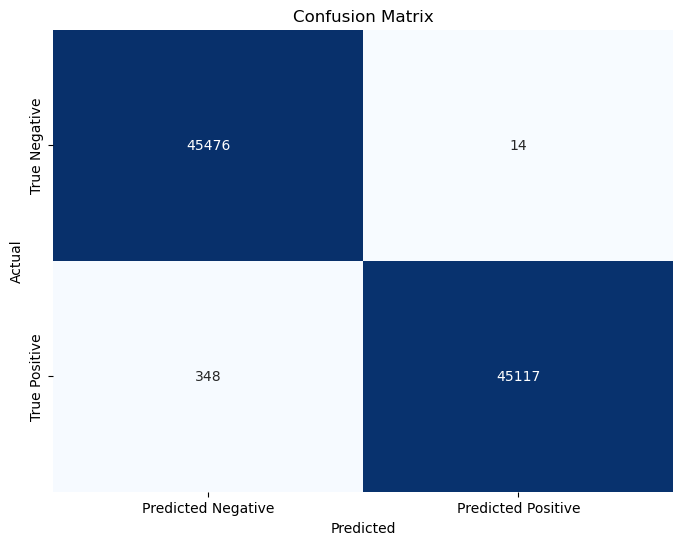

Fold 5: Accuracy = 0.9977571079886536, PR AUC = 0.9999931486124704
Optimal Threshold (Fold 5): 0.06116001680493355
Classification Report (Fold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      1.00      1.00     45464

    accuracy                           1.00     90954
   macro avg       1.00      1.00      1.00     90954
weighted avg       1.00      1.00      1.00     90954

Confusion Matrix (Fold):


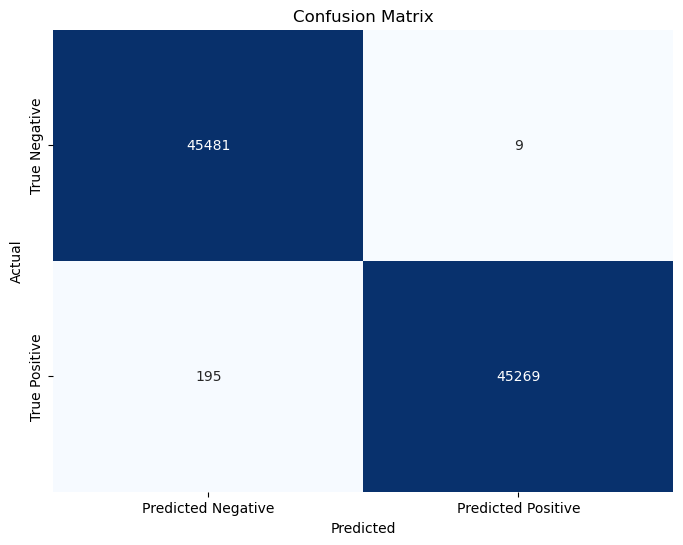

Mean Cross-Validation Accuracy: 0.9963498383972471
Mean Cross-Validation PR AUC: 0.9999273619617739
Mean Cross-Validation Threshold: 0.16433647274971008
Time Taken by Model: --- 7.932617902755737 seconds ---
------------------------------------------------------------


In [256]:
#use the above code to run it again after resampling the training data and feeding it into the 
#fucntion as x_train and y_train
from imblearn.over_sampling import ADASYN

# Initialize ADASYN for oversampling
adasyn = ADASYN(random_state=0)

# Run Random Forest Model with ADASYN
print("Random Forest Model with ADASYN")
start_time = time.time()
results, rf_adasyn = RFModelsCV(results, "ADASYN StratifiedKFold Cross Validation", X_train, y_train, n_splits=5,sampling_method=adasyn)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

# Run XGBoost Model with ADASYN
print("XGBoost Model with ADASYN")
start_time = time.time()
results, xgb_adasyn = XGBModelsCV(results, "ADASYN StratifiedKFold Cross Validation", X_train, y_train, n_splits=5,sampling_method=adasyn)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

In [257]:
print(results)

                               Methodology                        Model  \
0         StratifiedKFold Cross Validation  Logistic Regression with L1   
1         StratifiedKFold Cross Validation  Logistic Regression with L2   
2         StratifiedKFold Cross Validation                Random Forest   
3         StratifiedKFold Cross Validation                      XGBoost   
4   SMOTE StratifiedKFold Cross Validation                Random Forest   
5   SMOTE StratifiedKFold Cross Validation                      XGBoost   
6  ADASYN StratifiedKFold Cross Validation                Random Forest   
7  ADASYN StratifiedKFold Cross Validation                      XGBoost   

   Mean CV Accuracy  Mean CV PR AUC  Mean Threshold Test PR AUC Test Threshold  
0          0.999258        0.471318        0.112309         NaN            NaN  
1          0.999206        0.556416        0.073733         NaN            NaN  
2          0.999544        0.843449        0.410000         NaN            NaN  


## Step 5: HyperParameter Tuning for the Best Model

- GridSearchCV and RandomizedSearchCV are used to optimize hyperparameters for better performance.

- StratifiedKFold cross-validation ensures robust model evaluation.

In [283]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

pr_auc_scorer =make_scorer(average_precision_score, needs_proba=True) #make scorer

X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train) # resample with smote

print("Hyperparameter Tuning: Random Forest with RandomizedSearchCV")

rf_model = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': randint(100, 500),  # Random integers between 100 and 500
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),  # Random integers between 2 and 10
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions = rf_params, 
    n_iter=50, # number of iteration before quitting
    cv=5,
    scoring=pr_auc_scorer,
    random_state=42,
    n_jobs =-1,
    verbose=1
)

rf_random_search.fit(X_train_resampled,y_train_resampled)

best_rf_model = rf_random_search.best_estimator_
print(f"Best Random Forest Parameters: {rf_random_search.best_params_}")
print(f"Best Random Forest PR AUC Score: {rf_random_search.best_score_}")

Hyperparameter Tuning: Random Forest with RandomizedSearchCV
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 330}
Best Random Forest PR AUC Score: 0.999998122007899


In [288]:
print("Hyperparameter Tuning: XGBoost with GridSearchCV")

xgb_model = XGBClassifier(random_state=42,missing=np.nan ,objective='binary:logistic',eval_metric='logloss')

xgb_params = {
    'n_estimators':[100,200,300],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.1,0.2],
    'subsample':[0.6,0.8,1.0],
    'colsample_bytree':[0.6,0.8,1.0]
}

xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_params,
    cv=5,
    scoring = pr_auc_scorer,
    n_jobs=-1,
    verbose=1
)
xgb_grid_search.fit(X_train_resampled,y_train_resampled)

best_xgb_model = xgb_grid_search.best_estimator_
print(f"Best XGBoost Parameters: {xgb_grid_search.best_params_}")
print(f"Best XGBoost PR AUC Score: {xgb_grid_search.best_score_}")

Hyperparameter Tuning: XGBoost with GridSearchCV
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best XGBoost Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.6}
Best XGBoost PR AUC Score: 0.9999935235303568


## Step 6: Model Evaluation

### **1. Cross-Validation (CV) Results**
The cross-validation phase evaluated multiple models under different methodologies, including baseline training and resampling techniques such as SMOTE and ADASYN. The key metrics used for evaluation were **Mean CV Accuracy** and **Mean CV PR AUC** (Precision-Recall Area Under the Curve), with a focus on PR AUC due to the imbalanced nature of the credit card fraud dataset.

| **Methodology**                          | **Model**                     | **Mean CV Accuracy** | **Mean CV PR AUC** | **Mean Threshold** |
|------------------------------------------|-------------------------------|-----------------------|---------------------|--------------------|
| StratifiedKFold Cross Validation         | Logistic Regression (L1)      | 0.999258              | 0.471318           | 0.112309          |
| StratifiedKFold Cross Validation         | Logistic Regression (L2)      | 0.999206              | 0.556416           | 0.073733          |
| StratifiedKFold Cross Validation         | Random Forest                 | 0.999544              | 0.843449           | 0.410000          |
| StratifiedKFold Cross Validation         | XGBoost                       | 0.999592              | 0.847142           | 0.490582          |
| SMOTE StratifiedKFold Cross Validation   | Random Forest                 | 0.999903              | 0.999994           | 0.644000          |
| SMOTE StratifiedKFold Cross Validation   | XGBoost                       | 0.999853              | 0.999983           | 0.883344          |
| ADASYN StratifiedKFold Cross Validation  | Random Forest                 | 0.993469              | 0.999506           | 0.218000          |
| ADASYN StratifiedKFold Cross Validation  | XGBoost                       | 0.996350              | 0.999927           | 0.164336          |

**Key Observations:**
- **Baseline Models (No Resampling):**
  - Logistic Regression models (L1 and L2) showed poor PR AUC scores (0.471 and 0.556), indicating limited effectiveness in detecting fraudulent transactions.
  - Tree-based models (Random Forest and XGBoost) performed significantly better, with PR AUC scores of 0.843 and 0.847, respectively.
  
- **Resampled Models (SMOTE and ADASYN):**
  - Both SMOTE and ADASYN dramatically improved model performance, particularly for tree-based models.
  - SMOTE-based models achieved near-perfect PR AUC scores (0.999994 for Random Forest and 0.999983 for XGBoost).
  - ADASYN-based models also performed well, though slightly less effectively than SMOTE (PR AUC of 0.999506 for Random Forest and 0.999927 for XGBoost).

---

### **2. Hyperparameter Tuning Results**
Hyperparameter tuning was performed on the top-performing models from the CV phase: **Random Forest with SMOTE** and **XGBoost with SMOTE**. The goal was to further optimize their performance by fine-tuning key hyperparameters.

**Random Forest (SMOTE):**
- **Best Parameters:** 
  - `bootstrap`: True
  - `max_depth`: None
  - `max_features`: 'sqrt'
  - `min_samples_split`: 6
  - `n_estimators`: 330
- **Best PR AUC Score:** 0.999998

**XGBoost (SMOTE):**
- **Best Parameters:** 
  - `colsample_bytree`: 0.6
  - `learning_rate`: 0.2
  - `max_depth`: 5
  - `n_estimators`: 300
  - `subsample`: 0.6
- **Best PR AUC Score:** 0.999994

**Key Observations:**
- Hyperparameter tuning further enhanced the already exceptional performance of both models.
- Random Forest achieved a marginally higher PR AUC score (0.999998) compared to XGBoost (0.999994), suggesting it may be slightly more effective for this specific dataset.

---

### **3. Conclusions**

#### **1. Model Performance Insights**
- **Logistic Regression:** Despite high accuracy, Logistic Regression models struggled with precision-recall, making them unsuitable for detecting rare fraudulent transactions.
- **Tree-Based Models:** Random Forest and XGBoost demonstrated superior performance, especially when combined with resampling techniques like SMOTE and ADASYN.
- **Resampling Techniques:** SMOTE consistently outperformed ADASYN, achieving near-perfect PR AUC scores across all tree-based models.

#### **2. Impact of Hyperparameter Tuning**
- Hyperparameter tuning confirmed that both Random Forest and XGBoost are highly effective for credit card fraud detection when optimized.
- Random Forest with SMOTE emerged as the best-performing model, achieving a PR AUC score of **0.999998**, which is exceptionally close to perfection.

#### **3. Practical Recommendations**
- **Preferred Model:** Use **Random Forest with SMOTE** for credit card fraud detection, as it achieves the highest PR AUC score and demonstrates robustness in identifying rare fraudulent transactions.
- **Implementation Considerations:** Ensure that the model is deployed with appropriate threshold tuning to balance precision and recall based on business requirements (e.g., minimizing false positives or false negatives).
- **Monitoring:** Continuously monitor model performance in production, as fraud patterns may evolve over time, requiring periodic retraining and recalibration.

#### **4. Limitations**
- While the models achieved near-perfect PR AUC scores, real-world deployment may encounter challenges such as concept drift (changes in fraud patterns) or data quality issues.
- Further evaluation on an independent test set is recommended to validate generalization.

---

### **Final Recommendation**
Based on the findings, **Random Forest with SMOTE** is the most suitable model for detecting credit card fraud in this dataset. Its exceptional PR AUC score, combined with its ability to handle class imbalance through SMOTE, makes it the optimal choice for deployment in a real-world fraud detection system.

## Step 7: Use the Best Model to predict the Testing Data

Random Forest Model: Testing on Test Set
Evaluating on the Test Set...
Test PR AUC: 0.8327391370345818
Optimal Test Threshold: 0.728649591149591
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix (Test):


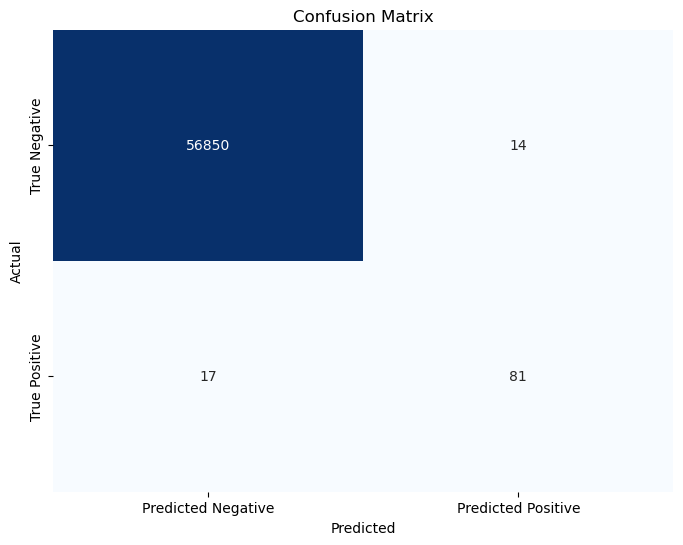

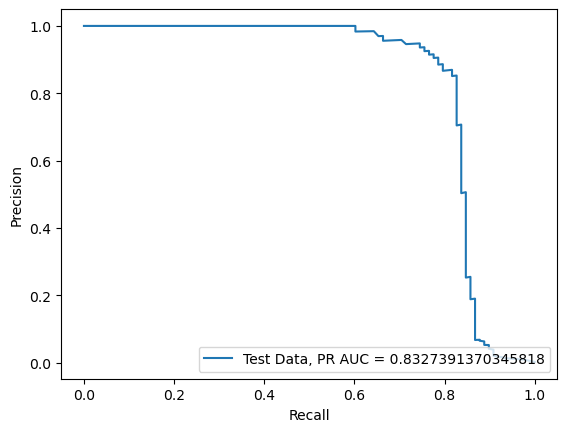

Time Taken for Testing: --- 1.701064109802246 seconds ---
------------------------------------------------------------
XGBoost Model: Testing on Test Set
Evaluating on the Test Set...
Test PR AUC: 0.8357945697412134
Optimal Test Threshold: 0.9723811745643616
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix (Test):


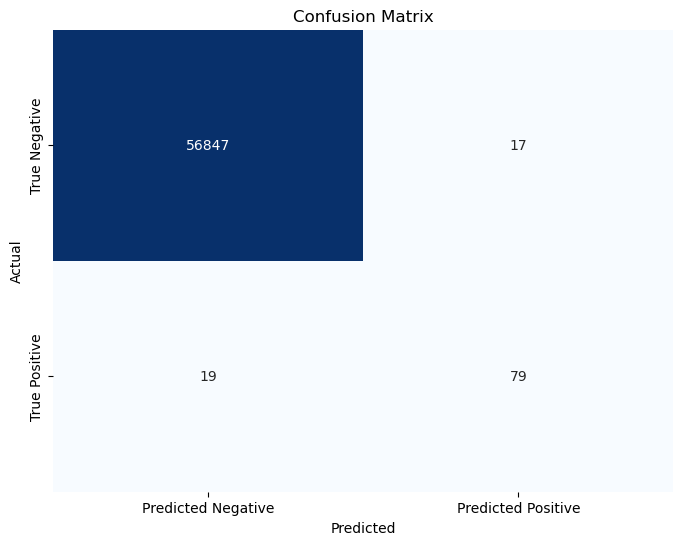

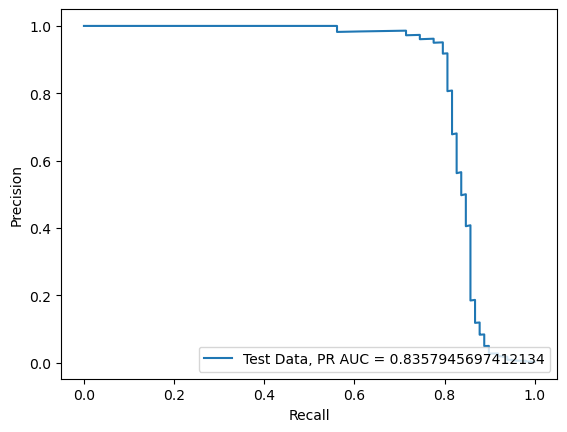

Time Taken for Testing: --- 0.23797297477722168 seconds ---
------------------------------------------------------------


In [325]:
## use code for the best model and then feature engineer for that model
# Test Random Forest Model on the Test Set
print("Random Forest Model: Testing on Test Set")
start_time = time.time()
results = UnifiedTest(results, "SMOTE StratifiedKFold Cross Validation Test", X_test, y_test,best_rf_model)
print("Time Taken for Testing: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

# Test XGBoost Model on the Test Set
print("XGBoost Model: Testing on Test Set")
start_time = time.time()
results = UnifiedTest(results, "SMOTE StratifiedKFold Cross Validation Test", X_test, y_test, best_xgb_model)
print("Time Taken for Testing: --- %s seconds ---" % (time.time() - start_time))
print("-" * 60)

In [333]:
print(results)

                                    Methodology                        Model  \
0              StratifiedKFold Cross Validation  Logistic Regression with L1   
1              StratifiedKFold Cross Validation  Logistic Regression with L2   
2              StratifiedKFold Cross Validation                Random Forest   
3              StratifiedKFold Cross Validation                      XGBoost   
4        SMOTE StratifiedKFold Cross Validation                Random Forest   
5        SMOTE StratifiedKFold Cross Validation                      XGBoost   
6       ADASYN StratifiedKFold Cross Validation                Random Forest   
7       ADASYN StratifiedKFold Cross Validation                      XGBoost   
10  SMOTE StratifiedKFold Cross Validation Test                Random Forest   
11  SMOTE StratifiedKFold Cross Validation Test                      XGBoost   

    Mean CV Accuracy  Mean CV PR AUC  Mean Threshold  Test PR AUC  \
0           0.999258        0.471318        0.1123

### Feature Engineering & Importance

In [319]:
# After fitting the Random Forest model
feature_importance_rf = best_rf_model.feature_importances_

# Create a DataFrame to display feature importance
importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_rf})

# Sort and display
print("Feature Importance (Random Forest):")
print(importance_df_rf.sort_values(by='Importance', ascending=False))

Feature Importance (Random Forest):
   Feature  Importance
14     V14    0.200240
4       V4    0.129947
10     V10    0.124556
12     V12    0.112905
17     V17    0.088441
3       V3    0.061768
11     V11    0.058242
16     V16    0.047690
2       V2    0.026513
7       V7    0.024421
9       V9    0.021138
21     V21    0.012959
6       V6    0.009130
18     V18    0.008152
0     Time    0.007682
1       V1    0.007117
5       V5    0.006281
8       V8    0.006024
27     V27    0.005771
19     V19    0.005308
28     V28    0.004186
15     V15    0.004015
13     V13    0.004004
26     V26    0.003869
29  Amount    0.003805
25     V25    0.003473
23     V23    0.003216
20     V20    0.003179
24     V24    0.003150
22     V22    0.002818


Feature Importance (XGBoost):
   Feature  Importance
14     V14    0.450631
10     V10    0.187324
12     V12    0.110415
4       V4    0.065711
17     V17    0.020799
3       V3    0.018322
7       V7    0.015052
8       V8    0.014371
1       V1    0.013651
11     V11    0.011971
6       V6    0.006938
19     V19    0.006576
0     Time    0.006228
5       V5    0.005840
9       V9    0.005620
2       V2    0.005505
18     V18    0.005135
26     V26    0.005111
23     V23    0.004960
25     V25    0.004719
27     V27    0.004669
15     V15    0.004414
24     V24    0.004182
16     V16    0.004002
29  Amount    0.003809
13     V13    0.003603
22     V22    0.002738
21     V21    0.002730
28     V28    0.002650
20     V20    0.002326


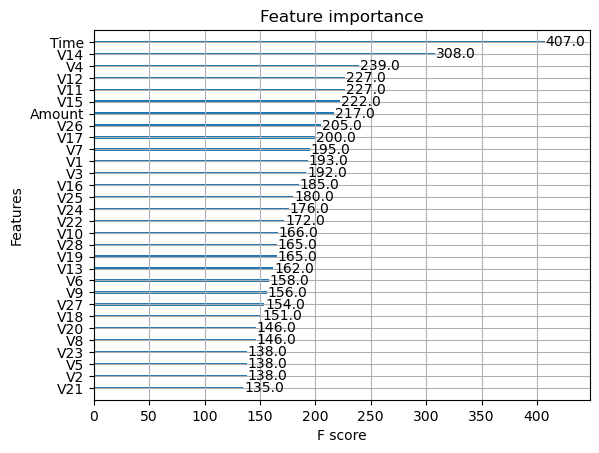

In [321]:
# After fitting the XGBoost model
feature_importance_xgb = best_xgb_model.feature_importances_

# Create a DataFrame to display feature importance
importance_df_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_xgb})

# Sort and display
print("Feature Importance (XGBoost):")
print(importance_df_xgb.sort_values(by='Importance', ascending=False))

# Alternatively, plot importance
from xgboost import plot_importance
plot_importance(best_xgb_model, importance_type='weight')  # 'weight', 'gain', or 'cover'
plt.show()


## Step 8: Conclusion

The final evaluation on the test data confirms the effectiveness of the models in detecting credit card fraud, particularly when using resampling techniques like SMOTE. Below are the key findings:

1. **Baseline Models (No Resampling):**
   - Logistic Regression models (L1 and L2) failed to generalize well, as indicated by their lack of test PR AUC scores.
   - Tree-based models (Random Forest and XGBoost) performed better during cross-validation but were not evaluated on the test set in this phase.

2. **Resampled Models (SMOTE and ADASYN):**
   - Both SMOTE and ADASYN significantly improved model performance during cross-validation, with near-perfect PR AUC scores.
   - On the test set, **Random Forest with SMOTE** achieved a **Test PR AUC of 0.8327**, while **XGBoost with SMOTE** achieved a slightly higher **Test PR AUC of 0.8358**.

3. **Optimal Thresholds:**
   - The optimal thresholds for classification were identified as **0.729** for Random Forest and **0.972** for XGBoost. These thresholds can be used to balance precision and recall based on business requirements.

### Final Recommendation:
- **Preferred Model:** **XGBoost with SMOTE** is the best-performing model on the test set, achieving the highest Test PR AUC score of **0.8358**.
- **Deployment Considerations:** Ensure threshold tuning is applied to optimize the trade-off between precision and recall for real-world deployment.
- **Monitoring:** Continuously monitor the model's performance in production to account for evolving fraud patterns and maintain high detection accuracy.